<a href="https://colab.research.google.com/github/TokushigeJunya/ForcedHNN/blob/main/Toda_exp1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import autograd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc, rcParams
from IPython.display import HTML
import random
import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

def hamiltonian_fn(coords):   #coords = [q0, ... , q19, p0, ... , p19]
    qs, ps = np.split(coords,2)
    H = np.zeros(1)   #toda lattice hamiltonian
    for i in range(qs.shape[0]):
        H += 0.5*ps[i]
        if i < qs.shape[0]-1:
            H += np.exp(qs[i]-qs[i+1]) + qs[i+1]-qs[i]
    return H

def get_trajectory(delta=None, k=None, t_span=[0,12], timescale=100, dim=40, noise_std=0.0):   #ノイズの大きさを変えたいときは、noise_stdを変える
    t_eval = np.linspace(t_span[0], t_span[1], int(timescale*(t_span[1]-t_span[0])))
    t_num = int(timescale*(t_span[1]-t_span[0]))

    if delta is None:
        delta = -5.0 + (np.random.rand()-0.5)*0.02

    if k is None:
        k = 1.0 + (np.random.rand()-0.5)*0.05

    n = dim//2
    beta = np.sinh(k)
    q = np.zeros((n,t_num))
    p = np.zeros((n,t_num))
    dqdt = np.zeros((n,t_num))
    dpdt = np.zeros((n,t_num))

    for i in range(t_num):
        for j in range(n):
            if j == 0:
                q[j][i] = np.log(1+np.exp(2*(k*(j-1)-beta*t_eval[i]+delta))) - np.log(1+np.exp(2*(k*j-beta*t_eval[i]+delta)))
                p[j][i] = (-2*beta)/(1+np.exp(-2*(k*(j-1)-beta*t_eval[i]+delta))) + (2*beta)/(1+np.exp(-2*(k*j-beta*t_eval[i]+delta)))
                dqdt[j][i] = p[j][i]
                dpdt[j][i] = - (beta ** 2)/((np.cosh((k*j-beta*t_eval[i]+delta))) ** 2)
            elif j == n-1:
                q[j][i] = np.log(1+np.exp(2*(k*(j-1)-beta*t_eval[i]+delta))) - np.log(1+np.exp(2*(k*j-beta*t_eval[i]+delta)))
                p[j][i] = (-2*beta)/(1+np.exp(-2*(k*(j-1)-beta*t_eval[i]+delta))) + (2*beta)/(1+np.exp(-2*(k*j-beta*t_eval[i]+delta)))
                dqdt[j][i] = p[j][i]
                dpdt[j][i] = (beta ** 2)/((np.cosh((k*(j-1)-beta*t_eval[i]+delta))) ** 2)
            else:
                q[j][i] = np.log(1+np.exp(2*(k*(j-1)-beta*t_eval[i]+delta))) - np.log(1+np.exp(2*(k*j-beta*t_eval[i]+delta)))
                p[j][i] = (-2*beta)/(1+np.exp(-2*(k*(j-1)-beta*t_eval[i]+delta))) + (2*beta)/(1+np.exp(-2*(k*j-beta*t_eval[i]+delta)))
                dqdt[j][i] = p[j][i]
                dpdt[j][i] = (beta ** 2)/((np.cosh((k*(j-1)-beta*t_eval[i]+delta))) ** 2) - (beta ** 2)/((np.cosh((k*j-beta*t_eval[i]+delta))) ** 2)

    for i in range(t_num):
        for j in range(n):
            q[j][i] += (np.random.rand()-0.5)*2*noise_std
            p[j][i] += (np.random.rand()-0.5)*2*noise_std
            dqdt[j][i] += (np.random.rand()-0.5)*2*noise_std
            dpdt[j][i] += (np.random.rand()-0.5)*2*noise_std

    return q, p, dqdt, dpdt, t_eval

def get_dataset(samples=70, test_split=0.8, noise_std=0.0):
    data = {'meta': locals()}

    # randomly sample inputs
    np.random.seed(0)
    torch.manual_seed(0)
    random.seed(0)
    xs, dxs = [], []
    for s in range(samples):
        q, p, dqdt, dpdt, t_eval = get_trajectory(noise_std=noise_std)
        xs.append( np.concatenate([q, p]).T )
        dxs.append( np.concatenate([dqdt, dpdt]).T )

    data['x'] = np.concatenate(xs)
    data['dx'] = np.concatenate(dxs).squeeze()

    # make a train/test split
    split_ix = int(len(data['x']) * test_split)
    split_data = {}
    for k in ['x', 'dx']:
        split_data[k], split_data['test_' + k] = data[k][:split_ix], data[k][split_ix:]
    data = split_data
    return data

In [ ]:
q, p, dqdt, dpdt, t_eval = get_trajectory(t_span=[0,5], delta=-5.0, k=1.0)
#q, p, dqdt, dpdt, t_eval = get_trajectory(t_span=[0,5])

dim = 40
t_span=[0,5]
timescale = 100
t_num = int(timescale*(t_span[1]-t_span[0]))

# fig, axオブジェクトを作成
fig, ax = plt.subplots()

# グラフのリスト作成
ims=[]
for i in range(t_num):
    n = dim//2
    ns = list(range(1,n+1))
    qs = np.zeros(n)
    for j in range(n):
        qs[j] = q[j][i]
    im = ax.plot(ns, qs, color='b')
    # グラフをリストに加える
    ims.append(im)

# 各軸のラベル
ax.set_xlabel(r"$n$", fontsize=15)
ax.set_ylabel(r"$q$", fontsize=15)
# グラフの範囲を設定
ax.set_xlim([-1,21])
ax.set_ylim([-3.0, 3.0])

# ArtistAnimationにfigオブジェクトとimsを代入してアニメーションを作成
anim = animation.ArtistAnimation(fig, ims)

# Google Colaboratoryの場合必要
rc('animation', html='jshtml')
plt.close()
anim.save('anim_q.mp4')

In [ ]:
dim = 40
t_span=[0,5]
timescale = 100
t_num = int(timescale*(t_span[1]-t_span[0]))

# fig, axオブジェクトを作成
fig, ax = plt.subplots()

# グラフのリスト作成
ims=[]
for i in range(t_num):
    n = dim//2
    ns = list(range(1,n+1))
    ps = np.zeros(n)
    for j in range(n):
        ps[j] = p[j][i]
    im = ax.plot(ns, ps, color='b')
    # グラフをリストに加える
    ims.append(im)

# 各軸のラベル
ax.set_xlabel(r"$n$", fontsize=15)
ax.set_ylabel(r"$p$", fontsize=15)
# グラフの範囲を設定
ax.set_xlim([-1,21])
ax.set_ylim([-2.0, 2.0])

# ArtistAnimationにfigオブジェクトとimsを代入してアニメーションを作成
anim = animation.ArtistAnimation(fig, ims)

# Google Colaboratoryの場合必要
rc('animation', html='jshtml')
plt.close()
anim.save('anim_p.mp4')

In [ ]:
class MLP(torch.nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.linear1 = torch.nn.Linear(input_dim, hidden_dim)
        self.linear2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = torch.nn.Linear(hidden_dim, output_dim, bias=None)

        for l in [self.linear1, self.linear2, self.linear3]:
            torch.nn.init.orthogonal_(l.weight) # use a principled initialization

        self.nonlinearity = torch.tanh

    def forward(self, x):
        h = self.nonlinearity( self.linear1(x) )
        h = self.nonlinearity( self.linear2(h) )
        return self.linear3(h)

class HNN(torch.nn.Module):
    '''Learn arbitrary vector fields that are sums of conservative and solenoidal fields'''
    def __init__(self, input_dim, differentiable_model, baseline=False):
        super(HNN, self).__init__()
        self.baseline = baseline
        self.differentiable_model = differentiable_model
        self.M = self.permutation_tensor(input_dim)

    def forward(self, x):
        # traditional forward pass
        return self.differentiable_model(x)

    def derivative(self, x, t=None):
        '''NEURAL ODE-STLE VECTOR FIELD'''
        if self.baseline:
            return self.differentiable_model(x)

        '''NEURAL HAMILTONIAN-STLE VECTOR FIELD'''
        F = self.forward(x) # traditional forward pass
        dF = torch.autograd.grad(F.sum(), x, create_graph=True)[0]

        return dF @ self.M.t()

    def permutation_tensor(self,n):
        M = torch.eye(n)
        M = torch.cat([M[n//2:], -M[:n//2]])
        return M

In [ ]:
print_every = 200

def L2_loss(u, v):
    return (u-v).pow(2).mean()

def train(baseline, total_steps, data):

    batch_size = 350

    # set random seed
    torch.manual_seed(0)
    np.random.seed(0)

    # init model and optimizer

    print("Training baseline model:" if baseline else "Training HNN model:")
    if baseline:
        differentiable_model = MLP(input_dim=40, hidden_dim=200, output_dim=40)
        model = HNN(input_dim=40, differentiable_model=differentiable_model, baseline=True)
    else:
        differentiable_model = MLP(input_dim=40, hidden_dim=200, output_dim=1)
        model = HNN(input_dim=40, differentiable_model=differentiable_model)
    optim = torch.optim.Adam(model.parameters(), weight_decay=1e-4)

    # arrange data
    x = torch.tensor( data['x'], requires_grad=True, dtype=torch.float32)
    test_x = torch.tensor( data['test_x'], requires_grad=True, dtype=torch.float32)
    dxdt = torch.tensor(data['dx'])
    test_dxdt = torch.tensor(data['test_dx'])

    # vanilla train loop
    stats = {'train_loss': [], 'test_loss': []}
    for step in range(total_steps+1):

        # train step
        if baseline:
            ixs = torch.randperm(x.shape[0])[:batch_size]
            dxdt_hat = model(x[ixs])
            loss = L2_loss(dxdt[ixs], dxdt_hat)
            loss.backward() ; optim.step() ; optim.zero_grad()

        else:
            ixs = torch.randperm(x.shape[0])[:batch_size]
            dxdt_hat = model.derivative(x[ixs])
            loss = L2_loss(dxdt[ixs], dxdt_hat)
            loss.backward() ; optim.step() ; optim.zero_grad()

        # run test data
        if baseline:
            ixs = torch.randperm(test_x.shape[0])[:batch_size]
            test_dxdt_hat = model(test_x[ixs])
            test_loss = L2_loss(test_dxdt[ixs], test_dxdt_hat)

        else:
            ixs = torch.randperm(test_x.shape[0])[:batch_size]
            test_dxdt_hat = model.derivative(test_x[ixs])
            test_loss = L2_loss(test_dxdt[ixs], test_dxdt_hat)

        # logging
        stats['train_loss'].append(loss.item())
        stats['test_loss'].append(test_loss.item())
        if step % print_every == 0:
            print("step {}, train_loss {:.4e}, test_loss {:.4e}".format(step, loss.item(), test_loss.item()))

    if baseline:
        train_dxdt_hat = model(x)

    else:
        train_dxdt_hat = model.derivative(x)

    train_dist = (dxdt - train_dxdt_hat).pow(2)

    if baseline:
        test_dxdt_hat = model(test_x)

    else:
        test_dxdt_hat = model.derivative(test_x)

    test_dist = (test_dxdt - test_dxdt_hat).pow(2)

    print('Final train loss {:.4e} +/- {:.4e}\nFinal test loss {:.4e} +/- {:.4e}'
      .format(train_dist.mean().item(), train_dist.std().item()/np.sqrt(train_dist.shape[0]),
              test_dist.mean().item(), test_dist.std().item()/np.sqrt(test_dist.shape[0])))

    return model, stats

In [ ]:
def integrate_model(model, t_span, y0, t_eval, baseline=True, rtol=1e-10, delta=-5.0, k=1.0, beta=0.0):

    if baseline:
        def fun(t, np_y):
            y = torch.tensor(np_y, requires_grad=True, dtype=torch.float32).view(1,40)
            dy = model(y).detach().numpy().reshape(-1)
            dy[0] += (beta ** 2)/((np.cosh((k*(-1)-beta*t+delta))) ** 2)
            dy[-1] += -(beta ** 2)/((np.cosh((k*(np_y.shape[0]-1)-beta*t+delta))) ** 2)
            return dy
        return solve_ivp(fun=fun, t_span=t_span, y0=y0, t_eval=t_eval, rtol=rtol)
    else:
        def fun(t, np_y):
            y = torch.tensor(np_y, requires_grad=True, dtype=torch.float32).view(1,40)
            dy = model.derivative(y).detach().numpy().reshape(-1)
            dy[0] += (beta ** 2)/((np.cosh((k*(-1)-beta*t+delta))) ** 2)
            dy[-1] += -(beta ** 2)/((np.cosh((k*(np_y.shape[0]-1)-beta*t+delta))) ** 2)
            return dy
        return solve_ivp(fun=fun, t_span=t_span, y0=y0, t_eval=t_eval, rtol=rtol)

In [ ]:
data = get_dataset()

In [ ]:
model_bnn, stats_bnn = train(baseline=True, total_steps=5000, data=data)
model_hnn, stats_hnn = train(baseline=False, total_steps=10000, data=data)

Training baseline model:
step 0, train_loss 1.4899e-01, test_loss 9.8157e-02
step 200, train_loss 1.7776e-03, test_loss 1.7431e-03
step 400, train_loss 1.1546e-03, test_loss 1.1568e-03
step 600, train_loss 1.0712e-03, test_loss 1.0787e-03
step 800, train_loss 1.0416e-03, test_loss 1.0366e-03
step 1000, train_loss 9.5163e-04, test_loss 1.0097e-03
step 1200, train_loss 9.5555e-04, test_loss 9.0339e-04
step 1400, train_loss 9.0849e-04, test_loss 9.6535e-04
step 1600, train_loss 9.1430e-04, test_loss 9.2679e-04
step 1800, train_loss 8.5231e-04, test_loss 9.1355e-04
step 2000, train_loss 9.0681e-04, test_loss 9.9555e-04
step 2200, train_loss 9.2043e-04, test_loss 9.0006e-04
step 2400, train_loss 7.9019e-04, test_loss 7.8605e-04
step 2600, train_loss 7.2450e-04, test_loss 6.6828e-04
step 2800, train_loss 5.8212e-04, test_loss 5.5678e-04
step 3000, train_loss 4.9700e-04, test_loss 5.2461e-04
step 3200, train_loss 4.3389e-04, test_loss 4.4616e-04
step 3400, train_loss 4.2863e-04, test_loss 4.4

In [ ]:
t_span = [0,5]
timescale = 100
t_eval = np.linspace(t_span[0], t_span[1], int(timescale*(t_span[1]-t_span[0])))
dim = 40
n = dim//2
delta = -5.0
k = 1.0
beta = np.sinh(k)

y0 = np.zeros(dim)
for i in range(n):
    y0[i] = np.log(1+np.exp(2*(k*(i-1)-beta*t_eval[0]+delta))) - np.log(1+np.exp(2*(k*i-beta*t_eval[0]+delta)))
    y0[i+n] = (-2*beta)/(1+np.exp(-2*(k*(i-1)-beta*t_eval[0]+delta))) + (2*beta)/(1+np.exp(-2*(k*i-beta*t_eval[0]+delta)))

integrate_model_bnn = integrate_model(model=model_bnn, t_span=t_span, y0=y0, t_eval=t_eval)
integrate_model_hnn = integrate_model(model=model_hnn, t_span=t_span, y0=y0, t_eval=t_eval, baseline=False)

In [ ]:
dim = 40
t_span=[0,5]
timescale = 100
t_num = int(timescale*(t_span[1]-t_span[0]))

# fig, axオブジェクトを作成
fig, ax = plt.subplots()

# グラフのリスト作成
ims=[]
for i in range(t_num):
    n = dim//2
    ns = list(range(1,n+1))
    qs = np.zeros(n)
    for j in range(n):
        qs[j] = integrate_model_bnn['y'][j][i]
    im = ax.plot(ns, qs, color='b')
    # グラフをリストに加える
    ims.append(im)

# 各軸のラベル
ax.set_xlabel(r"$n$", fontsize=15)
ax.set_ylabel(r"$q$", fontsize=15)
# グラフの範囲を設定
ax.set_xlim([-1,21])
ax.set_ylim([-3.0, 3.0])

# ArtistAnimationにfigオブジェクトとimsを代入してアニメーションを作成
anim = animation.ArtistAnimation(fig, ims)

# Google Colaboratoryの場合必要
rc('animation', html='jshtml')
plt.close()
anim.save('anim_bnn_q.mp4')

In [ ]:
dim = 40
t_span=[0,5]
timescale = 100
t_num = int(timescale*(t_span[1]-t_span[0]))

# fig, axオブジェクトを作成
fig, ax = plt.subplots()

# グラフのリスト作成
ims=[]
for i in range(t_num):
    n = dim//2
    ns = list(range(1,n+1))
    ps = np.zeros(n)
    for j in range(n):
        ps[j] = integrate_model_bnn['y'][j+n][i]
    im = ax.plot(ns, ps, color='b')
    # グラフをリストに加える
    ims.append(im)

# 各軸のラベル
ax.set_xlabel(r"$n$", fontsize=15)
ax.set_ylabel(r"$p$", fontsize=15)
# グラフの範囲を設定
ax.set_xlim([-1,21])
ax.set_ylim([-2.0, 2.0])

# ArtistAnimationにfigオブジェクトとimsを代入してアニメーションを作成
anim = animation.ArtistAnimation(fig, ims)

# Google Colaboratoryの場合必要
rc('animation', html='jshtml')
plt.close()
anim.save('anim_bnn_p.mp4')

In [ ]:
dim = 40
t_span=[0,5]
timescale = 100
t_num = int(timescale*(t_span[1]-t_span[0]))

# fig, axオブジェクトを作成
fig, ax = plt.subplots()

# グラフのリスト作成
ims=[]
for i in range(t_num):
    n = dim//2
    ns = list(range(1,n+1))
    ps = np.zeros(n)
    for j in range(n):
        qs[j] = integrate_model_hnn['y'][j][i]
    im = ax.plot(ns, qs, color='b')
    # グラフをリストに加える
    ims.append(im)

# 各軸のラベル
ax.set_xlabel(r"$n$", fontsize=15)
ax.set_ylabel(r"$q$", fontsize=15)
# グラフの範囲を設定
ax.set_xlim([-1,21])
ax.set_ylim([-3.0, 3.0])

# ArtistAnimationにfigオブジェクトとimsを代入してアニメーションを作成
anim = animation.ArtistAnimation(fig, ims)

# Google Colaboratoryの場合必要
rc('animation', html='jshtml')
plt.close()
anim.save('anim_hnn_q.mp4')

In [ ]:
dim = 40
t_span=[0,5]
timescale = 100
t_num = int(timescale*(t_span[1]-t_span[0]))

# fig, axオブジェクトを作成
fig, ax = plt.subplots()

# グラフのリスト作成
ims=[]
for i in range(t_num):
    n = dim//2
    ns = list(range(1,n+1))
    ps = np.zeros(n)
    for j in range(n):
        ps[j] = integrate_model_hnn['y'][j+n][i]
    im = ax.plot(ns, ps, color='b')
    # グラフをリストに加える
    ims.append(im)

# 各軸のラベル
ax.set_xlabel(r"$n$", fontsize=15)
ax.set_ylabel(r"$p$", fontsize=15)
# グラフの範囲を設定
ax.set_xlim([-1,21])
ax.set_ylim([-2.0, 2.0])

# ArtistAnimationにfigオブジェクトとimsを代入してアニメーションを作成
anim = animation.ArtistAnimation(fig, ims)

# Google Colaboratoryの場合必要
rc('animation', html='jshtml')
plt.close()
anim.save('anim_hnn_p.mp4')

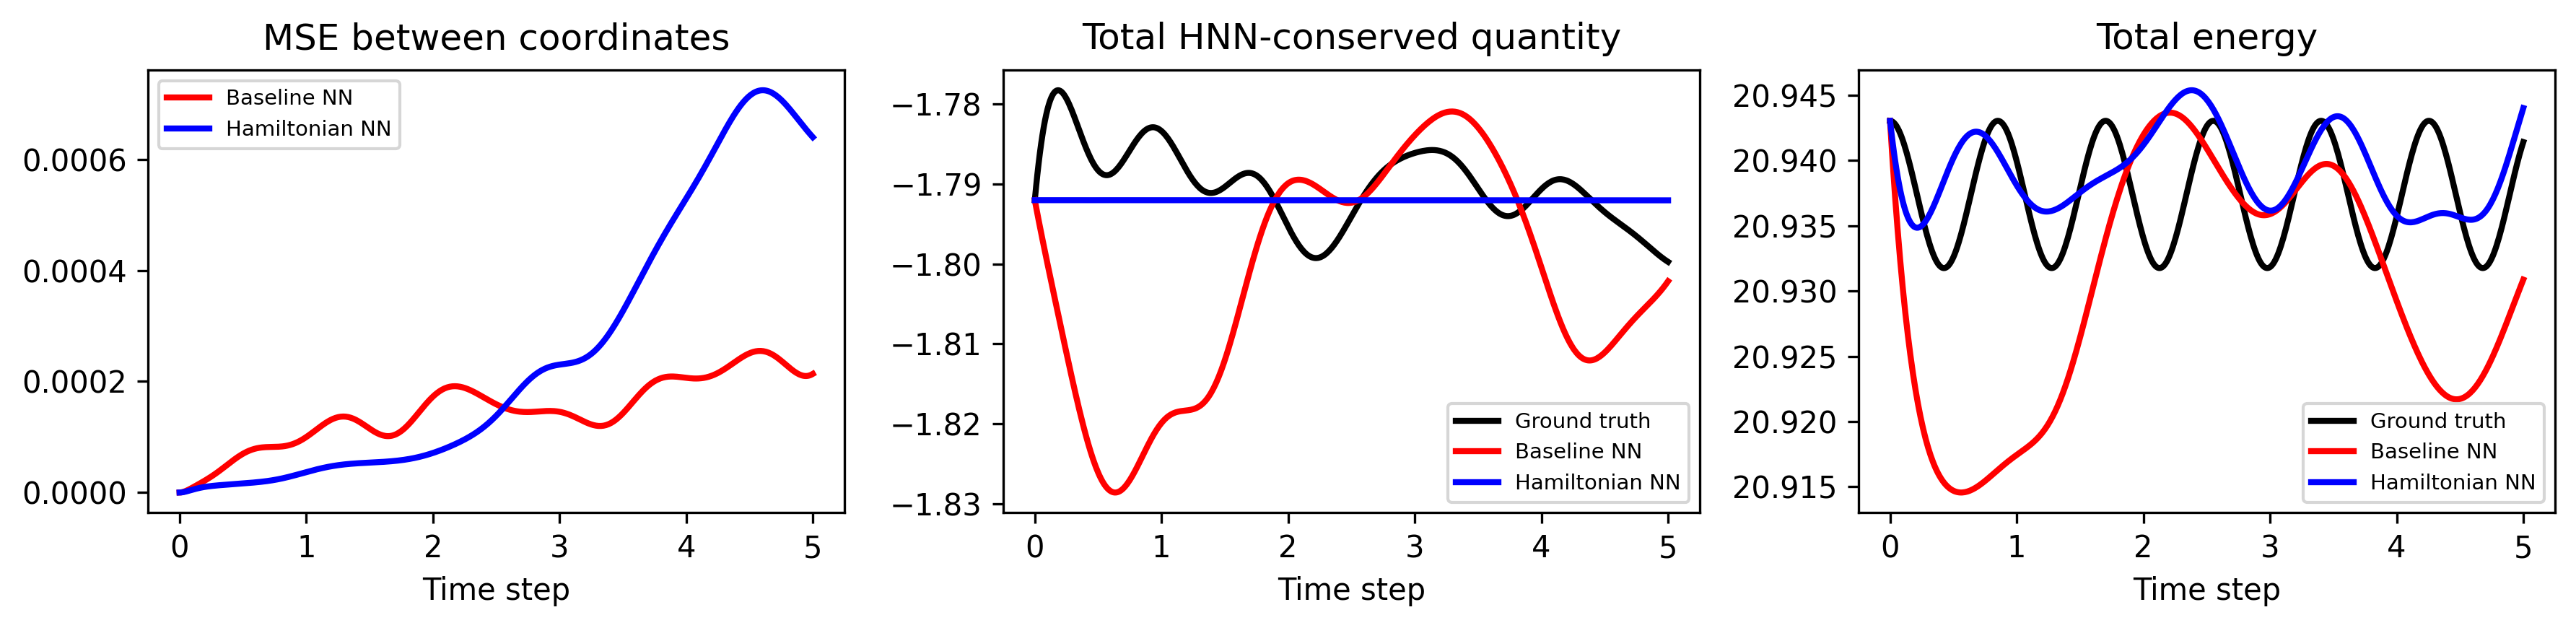

BNNによる予測エネルギーがep_nbdを外れる時間 0.018
HNNによる予測エネルギーがep_nbdを外れる時間 0.414


In [ ]:
DPI = 300
LINE_SEGMENTS = 10
ARROW_SCALE = 30
ARROW_WIDTH = 6e-3
LINE_WIDTH = 2

noise_std = 0.0   #ノイズの設定を忘れないこと

fig = plt.figure(figsize=(12, 3), facecolor='white', dpi=DPI)
tpad =7
t_span = [0,5]
timescale = 100
t_eval = np.linspace(t_span[0], t_span[1], int(timescale*(t_span[1]-t_span[0])))

q, p, dqdt, dpdt, t_eval = get_trajectory(t_span=[0,5], delta=-5.0, k=1.0, timescale=100, noise_std=0.0)

# integrate along ground truth vector field
true_y = np.concatenate([q, p]).T

# ノイズの影響を補正するために時間を再スケールする必要があることに注意
t_span[1] *= 1 + .9*noise_std
t_eval *= 1 + .9*noise_std

# integrate along baseline vector field
base_path = integrate_model(model_bnn, y0=y0, t_span=t_span, t_eval=t_eval, rtol=1e-12)
base_y = base_path['y'].T

# integrate along HNN vector field
hnn_path = integrate_model(model_hnn, y0=y0, t_span=t_span, t_eval=t_eval, baseline=False, rtol=1e-12)
hnn_y = hnn_path['y'].T

plt.subplot(1,3,1)
plt.title("MSE between coordinates", pad=tpad) ; plt.xlabel('Time step')
plt.plot(t_eval, ((true_y-base_y)**2).mean(-1), 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, ((true_y-hnn_y)**2).mean(-1), 'b-', label='Hamiltonian NN', linewidth=2)
plt.legend(fontsize=7)

plt.subplot(1,3,2)
plt.title("Total HNN-conserved quantity", pad=tpad)
plt.xlabel('Time step')
true_hq = model_hnn(torch.Tensor(true_y)).detach().numpy().squeeze()
base_hq = model_hnn(torch.Tensor(base_y)).detach().numpy().squeeze()
hnn_hq = model_hnn(torch.Tensor(hnn_y)).detach().numpy().squeeze()
plt.plot(t_eval, true_hq, 'k-', label='Ground truth', linewidth=2)
plt.plot(t_eval, base_hq, 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, hnn_hq, 'b-', label='Hamiltonian NN', linewidth=2)
plt.legend(fontsize=7)

plt.subplot(1,3,3)
plt.title("Total energy", pad=tpad)
plt.xlabel('Time step')
true_e = np.stack([hamiltonian_fn(c) for c in true_y]).squeeze()
base_e = np.stack([hamiltonian_fn(c) for c in base_y]).squeeze()
hnn_e = np.stack([hamiltonian_fn(c) for c in hnn_y]).squeeze()
plt.plot(t_eval, true_e, 'k-', label='Ground truth', linewidth=2)
plt.plot(t_eval, base_e, 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, hnn_e, 'b-', label='Hamiltonian NN', linewidth=2)
plt.legend(fontsize=7)
plt.tight_layout() ; plt.show()

ep_nbd = 0.01
for num in range(0,500):
    if abs(true_e[num]-base_e[num]) > ep_nbd:
        print("BNNによる予測エネルギーがep_nbdを外れる時間",num*(1+.9*noise_std)/500)
        break
    if num == 499:
        print("BNNによる予測エネルギーはep_nbdを外れない")

for num in range(0,500):
    if abs(true_e[num]-hnn_e[num]) > ep_nbd:
        print("HNNによる予測エネルギーがep_nbdを外れる時間",num*(1+.9*noise_std)/500)
        break
    if num == 499:
        print("HNNによる予測エネルギーはep_nbdを外れない")